# Mine domain 2. Extract subgroups with high concentration of PHAs

In [1]:
import pickle
from copy import copy, deepcopy
import numpy as np
import pandas as pd
from sklearn import neighbors, svm
import matplotlib as mpl

# from sklearn.neighbors.kde import KernelDensity
# from sklearn import tree
# import pydotplus

# Import Asterion modules
import read_database as rdb
import learn_data as ld
import asterion_learn as al
import visualize_data as vd

# Plotting settings for the current notebook
%matplotlib inline
font = {'size': 14}
mpl.rc('font', **font)
plotgrid = np.array([[0.0, 0.0], [1.0, 1.0]])

** Load NEAs from the 2-nd domain **

In [2]:
dirpath = './asteroid_data/'
gen_datasets = ['haz_gen', 'nohaz_gen']
genu_datasets = ['haz_gen', 'nohaz_gen']
name_sufixes = ['_sg2.p', '_sg2_rest.p']

In [3]:
dumps_gen = [dirpath + ds + ns for ns in name_sufixes for ds in gen_datasets]
dumps_genu = [dirpath + ds + ns for ns in name_sufixes for ds in genu_datasets]

haz_gen, nohaz_gen, haz_gen_rest, nohaz_gen_rest = map(rdb.loadObject, dumps_gen)
haz_genu, nohaz_genu, haz_genu_rest, nohaz_genu_rest = map(rdb.loadObject, dumps_genu)

** Investigate distributions of asteroids' orbital parameters in the 2-nd domain **

In [4]:
# vd.display_allparams([haz_gen, nohaz_gen], vd.combs, vd.colnames)

** Declare containers to collect subgroups **

In [5]:
haz_extracted = []
nohaz_trapped = []

---
## Extract Atiras and Atens

In [6]:
haz_gen_atiras, haz_gen_atiras_num = rdb.get_atiras(haz_gen)
nohaz_gen_atiras, nohaz_gen_atiras_num = rdb.get_atiras(nohaz_gen)

In [7]:
haz_gen_atens, naz_gen_atens_num = rdb.get_atens(haz_gen)
nohaz_gen_atens, nohaz_gen_atens_num = rdb.get_atens(nohaz_gen)

In [8]:
haz_gen_atiras_atens = pd.concat((haz_gen_atiras, haz_gen_atens))
nohaz_gen_atiras_atens = pd.concat((nohaz_gen_atiras, nohaz_gen_atens))
haz_gen_atiras_atens_num = len(haz_gen_atiras_atens)
nohaz_gen_atiras_atens_num = len(nohaz_gen_atiras_atens)

In [9]:
# vd.display_allparams([haz_gen_atiras, nohaz_gen_atiras], vd.combs, vd.colnames)
# vd.display_allparams([haz_gen_atens, nohaz_gen_atens], vd.combs, vd.colnames)
# vd.display_allparams([haz_gen_atiras_atens, nohaz_gen_atiras_atens], vd.combs, vd.colnames)

In [10]:
# hg_aa, nhg_aa = haz_gen_atiras_atens, nohaz_gen_atiras_atens

# haz_gen_aa_sq = hg_aa[hg_aa.q <= 0.55]
# nohaz_gen_aa_sq = nhg_aa[nhg_aa.q <= 0.55]

# haz_gen_aa_bq = hg_aa[hg_aa.q > 0.55]
# nohaz_gen_aa_bq = nhg_aa[nhg_aa.q > 0.55]

In [11]:
# vd.display_allparams([haz_gen_aa_sq, nohaz_gen_aa_sq], vd.combs, vd.colnames)

In [12]:
# vd.display_allparams([haz_gen_aa_bq, nohaz_gen_aa_bq], vd.combs, vd.colnames)

** Cut off non-hazardous piece **

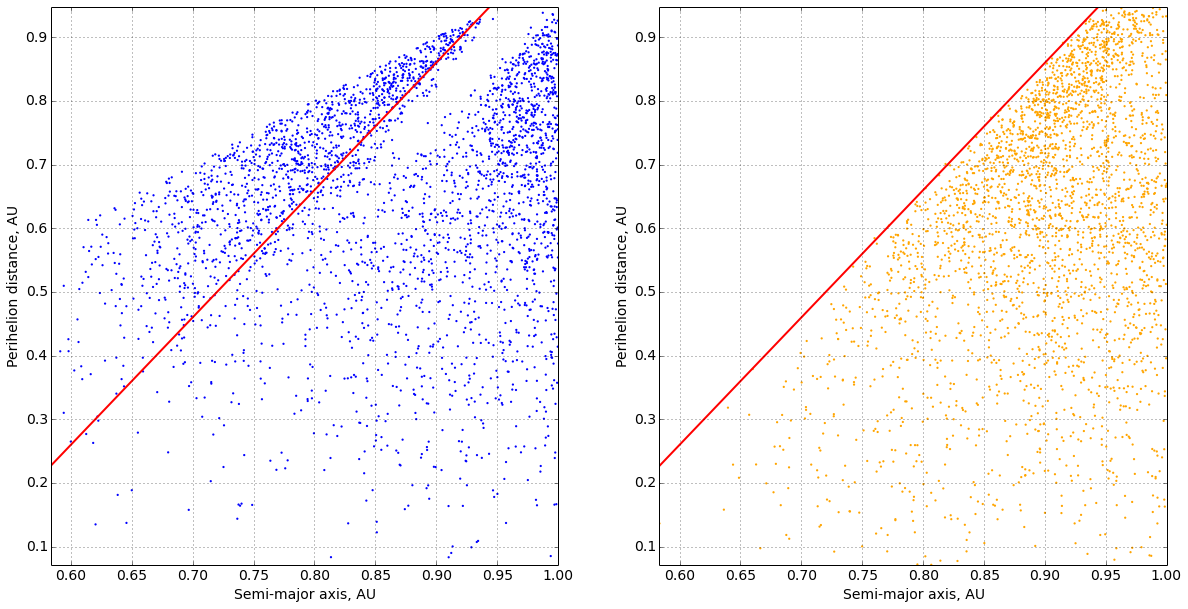

In [15]:
cutcol = ['a', 'q']
labels = [vd.colnames[nm] for nm in cutcol]
haz_cut, nohaz_cut = ld.cut_params(haz_gen_atiras_atens, nohaz_gen_atiras_atens, cutcol)
# haz_gen_cut, nohaz_gen_cut = ld.cut_params(haz_gen, nohaz_gen, cutcol)
# haz_gen_cut, nohaz_gen_cut = ld.cut_2params(cutcol, [haz_gen_sg1b, nohaz_gen_sg1b])
p1, p2 = [[0.545, 0.15], [0.945, 0.95]]
vd.linearcut_plot(p1, p2, haz_cut, nohaz_cut, labels=labels)

In [16]:
splitres = ld.split_by_line(haz_gen_atiras_atens, nohaz_gen_atiras_atens, [p1, p2], cutcol)

haz_gen_atiras_atens_qa, nohaz_gen_atiras_atens_qa = splitres[0]
haz_gen_atiras_atens_qa__, nohaz_gen_atiras_atens_qa__ = splitres[1]

PHA purity of the left subset: 0.603624244949
PHA purity of the right subset: 0.00432152117545


** Amplify datasets by their symetric copies over the 'w' parameter **

In [17]:
haz_gen_atiras_atens_qa_se = ld.add_doublemirror_column(haz_gen_atiras_atens_qa, 'w', 180.0)
nohaz_gen_atiras_atens_qa_se = ld.add_doublemirror_column(nohaz_gen_atiras_atens_qa, 'w', 180.0)

** Split Atiras and Atens by w-a-i surface **

In [18]:
cutcol = ['w', 'a', 'i']
clf_aa_wai = svm.SVC(gamma=80.0, C=0.1, class_weight={0: 1.5}) #class_weight={0: 1.5} 
#(20 0.5), (30 0.1) (200 0.1)
splitres = al.split_by_clf(clf_aa_wai, cutcol, haz_gen_atiras_atens_qa_se,
                                               nohaz_gen_atiras_atens_qa_se,
                                               haz_gen_atiras_atens_qa,
                                               nohaz_gen_atiras_atens_qa)

haz_gen_atiras_atens_wqa, nohaz_gen_atiras_atens_wqa = splitres[0]
haz_gen_atiras_atens_wqa__, nohaz_gen_atiras_atens_wqa__ = splitres[1]
aa_wai_sc = splitres[2]

purity of PHA region: 0.893493576461
number of PHAs in the PHA region: 2156
number of NHAs in the PHA region: 257

purity of NHA region: 0.689279731993
number of PHAs in the NHA region: 742
number of NHAs in the NHA region: 1646

fraction of correctly classified PHAs: 0.743961352657


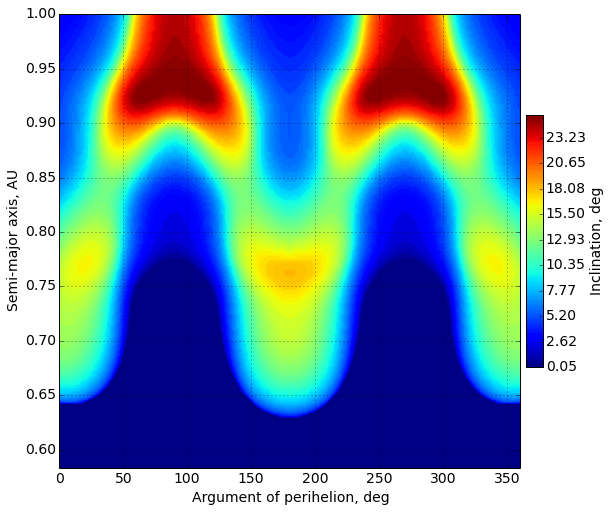

In [21]:
labels = [vd.colnames[nm] for nm in cutcol]
vd.plot_clf3d(clf_aa_wai, num=200, labels=labels, figsize=(8,7), mode='2d', scales=aa_wai_sc) 

In [22]:
haz_extracted.append(haz_gen_atiras_atens_wqa)
nohaz_trapped.append(nohaz_gen_atiras_atens_wqa)

** Analyze rest of Atiras and Atens **

In [23]:
# vd.display_allparams([haz_gen_atiras_atens_wqa__, nohaz_gen_atiras_atens_wqa__], vd.combs, vd.colnames)

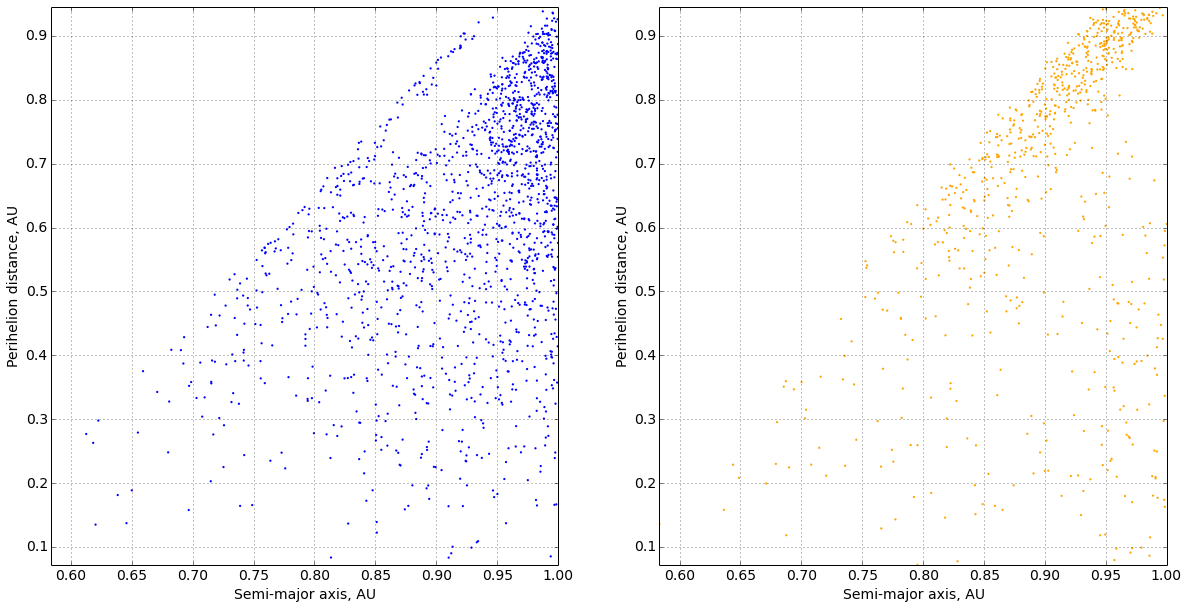

In [24]:
cutcol = ['a', 'q']
labels = [vd.colnames[nm] for nm in cutcol]
vd.display_param2d(cutcol, labels, [haz_gen_atiras_atens_wqa__, nohaz_gen_atiras_atens_wqa__])

** Select asteroids with high values of perihelion distance **

In [25]:
hg_aa_wqa__, nhg_aa_wqa__ = haz_gen_atiras_atens_wqa__, nohaz_gen_atiras_atens_wqa__
haz_gen_aa_wqa__bq = hg_aa_wqa__[hg_aa_wqa__.q > 0.5]
nohaz_gen_aa_wqa__bq = nhg_aa_wqa__[nhg_aa_wqa__.q > 0.5]

In [26]:
# cutcol = ['a', 'q']
# labels = [vd.colnames[nm] for nm in cutcol]
# vd.display_param2d(cutcol, labels, [haz_gen_atiras_atens_wqar, nohaz_gen_atiras_atens_wqar])

** Extract PHA region **

In [27]:
cutcol = ['a', 'q']
clf_aa_aq = svm.SVC(gamma=8.0, C=1000.0, class_weight={0: 1.5}) #class_weight={0: 1.5} 
#(20 0.5), (30 0.1) (200 0.1)
splitres = al.split_by_clf(clf_aa_aq, cutcol, haz_gen_aa_wqa__bq,
                                                nohaz_gen_aa_wqa__bq)

haz_gen_aa_aq, nohaz_gen_aa_aq = splitres[0]
haz_gen_aa_aq__, nohaz_gen_aa_aq__ = splitres[1]
aa_aq_sc = splitres[2]

purity of PHA region: 0.904761904762
number of PHAs in the PHA region: 342
number of NHAs in the PHA region: 36

purity of NHA region: 0.842219020173
number of PHAs in the NHA region: 219
number of NHAs in the NHA region: 1169

fraction of correctly classified PHAs: 0.609625668449


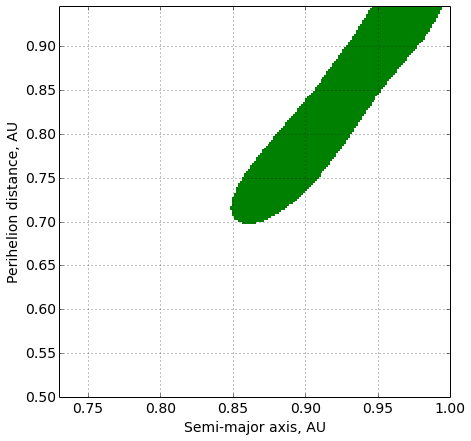

In [28]:
plotgrid = np.array([[0.0, 0.0], [1.0, 1.0]])
labels = [vd.colnames[nm] for nm in cutcol]
vd.plot_classifier(plotgrid, clf_aa_aq, num=200, figsize=(7,7), scales=aa_aq_sc, 
                   labels = labels, cmap='ocean_r')

In [29]:
haz_extracted.append(haz_gen_aa_aq)
nohaz_trapped.append(nohaz_gen_aa_aq)

---
## Extract Apollos

In [30]:
haz_gen_apollo, haz_gen_apollo_num = rdb.get_apollos(haz_gen)
nohaz_gen_apollo, nohaz_gen_apollo_num = rdb.get_apollos(nohaz_gen)

In [31]:
# vd.display_allparams([haz_gen_apollo, nohaz_gen_apollo], vd.combs, vd.colnames)

** Amplify datasets by it's symmetric copies over the 'w' parameter **

In [32]:
haz_gen_apollo_se = ld.add_doublemirror_column(haz_gen_apollo, 'w', 180.0)
nohaz_gen_apollo_se = ld.add_doublemirror_column(nohaz_gen_apollo, 'w', 180.0)

In [33]:
# haz_gen_apollo_see = ld.extend_by_copies(haz_gen_apollo_se, 'w', extend_factor=0.25)
# nohaz_gen_apollo_see = ld.extend_by_copies(nohaz_gen_apollo_se, 'w', extend_factor=0.25)

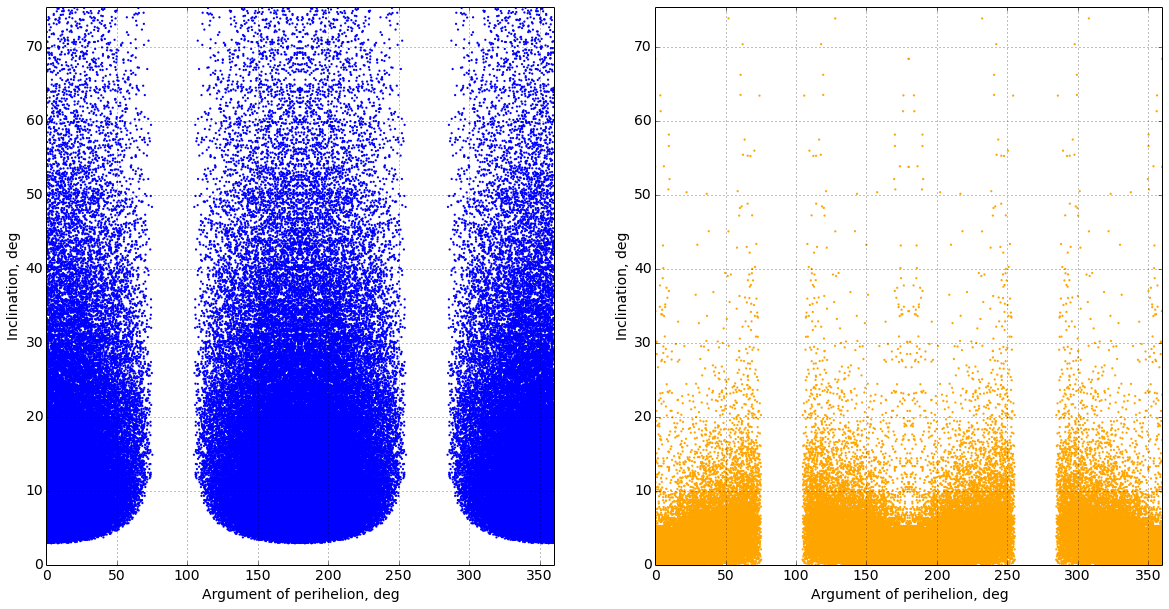

In [34]:
cutcol = ['w', 'i']
labels = [vd.colnames[nm] for nm in cutcol]
vd.display_param2d(cutcol, labels, [haz_gen_apollo_se, nohaz_gen_apollo_se])

** Extract pure PHA region from the bottom of w-i distribution **

In [35]:
clf_apollo_wi = svm.SVC(gamma=30., C=0.1, class_weight={0: 10})
splitres = al.split_by_clf(clf_apollo_wi, cutcol, haz_gen_apollo_se, 
                                                  nohaz_gen_apollo_se, 
                                                  haz_gen_apollo, 
                                                  nohaz_gen_apollo)

haz_gen_apollo_wi, nohaz_gen_apollo_wi = splitres[0]
haz_gen_apollo_wi__, nohaz_gen_apollo_wi__ = splitres[1]
apollo_wi_sc = splitres[2]

purity of PHA region: 0.999908349372
number of PHAs in the PHA region: 10910
number of NHAs in the PHA region: 1

purity of NHA region: 0.818681537542
number of PHAs in the NHA region: 9104
number of NHAs in the NHA region: 41106

fraction of correctly classified PHAs: 0.545118417108


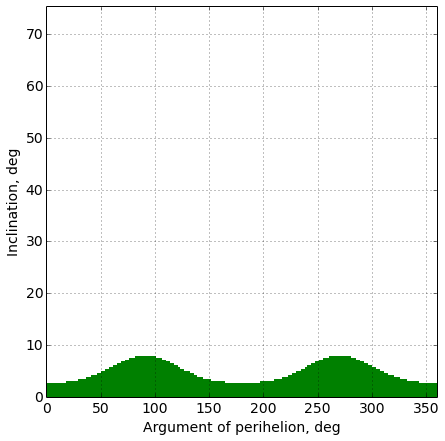

In [36]:
vd.plot_classifier(plotgrid, clf_apollo_wi, num=200, scales=apollo_wi_sc, 
                   labels=labels, cmap='ocean_r', figsize=(7,7))

In [37]:
haz_extracted.append(haz_gen_apollo_wi)
nohaz_trapped.append(nohaz_gen_apollo_wi)

** Analyze asteroids left after the 'w-i' split **

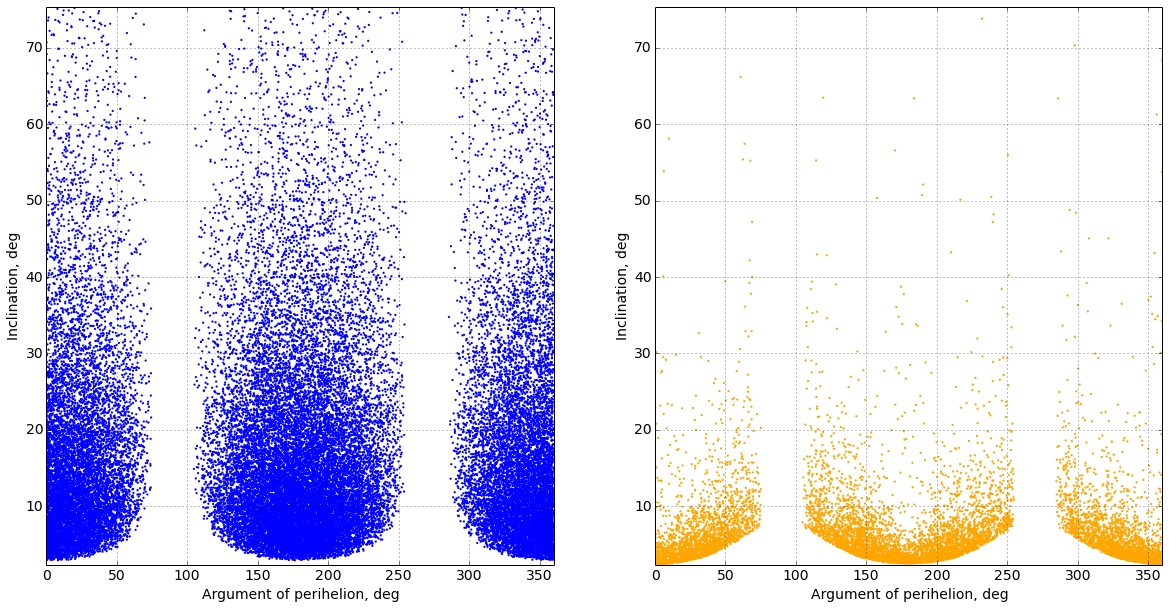

In [38]:
vd.display_param2d(cutcol, labels, [haz_gen_apollo_wi__, nohaz_gen_apollo_wi__])

In [39]:
# vd.display_allparams([haz_gen_apollo_wi__, nohaz_gen_apollo_wi__], vd.combs, vd.colnames)

** Amplify datasets by their symmetric copies over the 'w' parameter **

In [40]:
haz_gen_apollo_wi__se = ld.add_doublemirror_column(haz_gen_apollo_wi__, 'w', 180.0)
nohaz_gen_apollo_wi__se = ld.add_doublemirror_column(nohaz_gen_apollo_wi__, 'w', 180.0)

** Prepare 'w-q' domain mask to exclude out-of-domain points from the plot **

In [41]:
cutcol = ['w', 'q']
clfmask = svm.SVC(gamma=10.0, C=100.0, class_weight={1: 10})
clfmask = al.sgmask_clf(haz_gen_apollo_wi__se, nohaz_gen_apollo_wi__se, 
                        haz_genu_rest, nohaz_genu_rest, clfmask, cutcol)

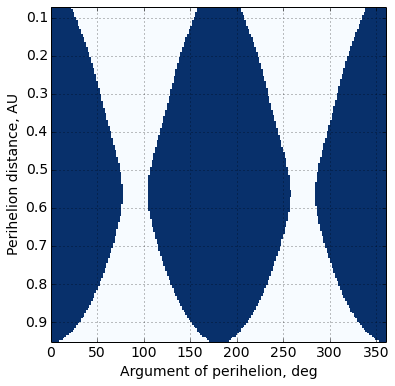

In [42]:
labels = [vd.colnames[nm] for nm in cutcol]
mask_scales = ld.dfcommon_bounds([haz_gen_apollo_wi__se, nohaz_gen_apollo_wi__se], cutcol)
vd.plot_classifier(plotgrid, clfmask, num=200, figsize=(6,6), scales=mask_scales, 
                   labels = labels, cmap='Blues', invertaxes=[0, 1])

** Split Apollos by the 'w-q-i' surface **

In [43]:
cutcol = ['w', 'q', 'i']
clf_apollo_wqi = svm.SVC(gamma=100.0, C=2.0, class_weight={0: 1.5})
#(20 0.5), (30 0.1) (30 1.0) (40 2) (50 2)!!!
splitres = al.split_by_clf(clf_apollo_wqi, cutcol, haz_gen_apollo_wi__se,
                                                   nohaz_gen_apollo_wi__se,
                                                   haz_gen_apollo_wi__,
                                                   nohaz_gen_apollo_wi__)

haz_gen_apollo_wqi, nohaz_gen_apollo_wqi = splitres[0]
haz_gen_apollo_wqi__, nohaz_gen_apollo_wqi__ = splitres[1]
apollo_wqi_sc = splitres[2]

purity of PHA region: 0.88338762215
number of PHAs in the PHA region: 6780
number of NHAs in the PHA region: 895

purity of NHA region: 0.94536264253
number of PHAs in the NHA region: 2324
number of NHAs in the NHA region: 40211

fraction of correctly classified PHAs: 0.744727592267


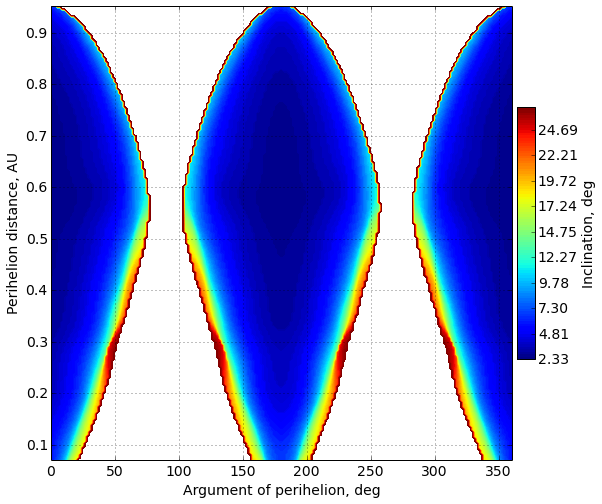

In [44]:
cutcol = ['w', 'q', 'i']
labels = [vd.colnames[nm] for nm in cutcol]
vd.plot_clf3d(clf_apollo_wqi, num=200, labels=labels, figsize=(8,7), mode='2d', 
              scales=apollo_wqi_sc, clf_masks=[(clfmask, 0)]) 

In [45]:
haz_extracted.append(haz_gen_apollo_wqi)
nohaz_trapped.append(nohaz_gen_apollo_wqi)

** Analyze the rest of Apollos **

In [46]:
# vd.display_allparams([haz_gen_apollo_wqi__, nohaz_gen_apollo_wqi__], vd.combs, vd.colnames)

** Apply 4-dimensional split **

In [47]:
cutcol = ['w', 'q', 'i', 'a']
clf_apollo_4d = svm.SVC(gamma=80.0, C=10) #class_weight={0: 1.5} 
#(20 0.5), (30 0.1) (30 1.0)
splitres = al.split_by_clf(clf_apollo_4d, cutcol,  haz_gen_apollo_wqi__,
                                                   nohaz_gen_apollo_wqi__,
                                                   haz_gen_apollo_wqi__,
                                                   nohaz_gen_apollo_wqi__)

haz_gen_apollo_wqi__4d, nohaz_gen_apollo_wqi__4d = splitres[0]
haz_gen_apollo_wqi__4d__, haz_gen_apollo_wqi__4d__ = splitres[1]
haz_gen_apollo_wqi__4d_sc = splitres[2]

purity of PHA region: 0.908051948052
number of PHAs in the PHA region: 1748
number of NHAs in the PHA region: 177

purity of NHA region: 0.985816301404
number of PHAs in the NHA region: 576
number of NHAs in the NHA region: 40034

fraction of correctly classified PHAs: 0.752151462995


** Try applying low-dimensional splits for the rest of Apollos **

In [48]:
print len(haz_gen_apollo_wqi__)

2324


In [49]:
# vd.display_allparams([haz_gen_apollo_aq, nohaz_gen_apollo_aq], vd.combs, vd.colnames)

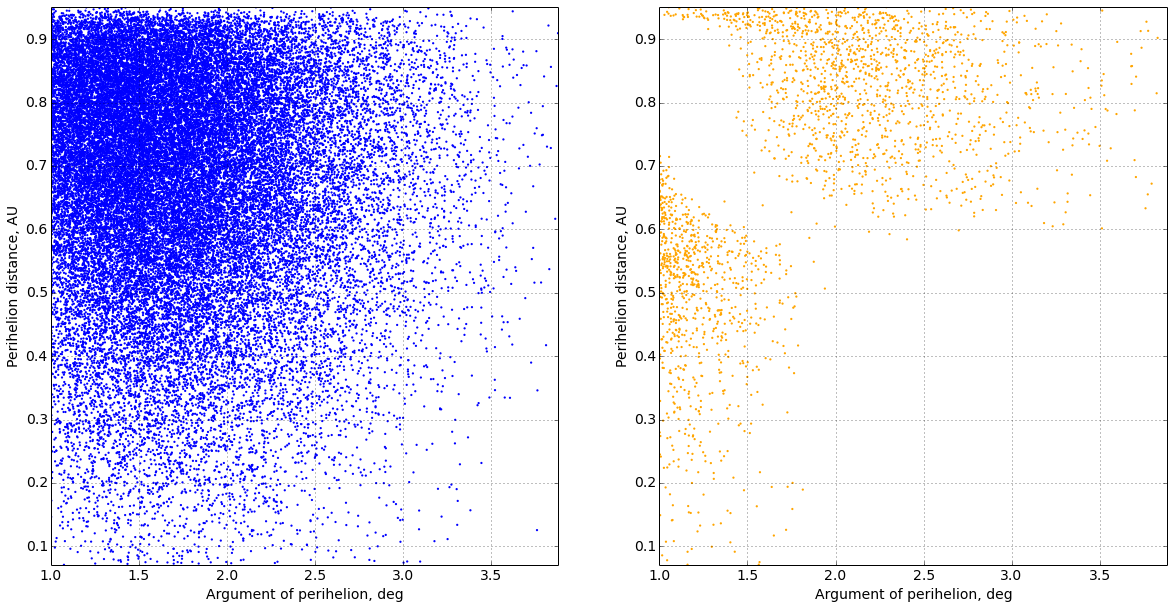

In [50]:
cutcol = ['a', 'q']
vd.display_param2d(cutcol, labels, [haz_gen_apollo_wqi__, nohaz_gen_apollo_wqi__])

In [51]:
# hg_wqi__, nhg_wqi__ = haz_gen_apollo_wqi__, nohaz_gen_apollo_wqi__

# hg_wqi__bq = hg_wqi__[hg_wqi__.q > 0.65]
# nhg_wqi__bq = nhg_wqi__[nhg_wqi__.q > 0.65]

In [52]:
# vd.display_allparams([hg_wqi__bq, nhg_wqi__bq], vd.combs, vd.colnames)

** Extract two regions with PHAs **

In [53]:
haz_gen_apollo_qa_top = haz_gen_apollo_wqi__[haz_gen_apollo_wqi__.q > 0.65]
nohaz_gen_apollo_qa_top = nohaz_gen_apollo_wqi__[nohaz_gen_apollo_wqi__.q > 0.65]

haz_gen_apollo_qa_top = haz_gen_apollo_qa_top[haz_gen_apollo_qa_top.a > 1.5]
nohaz_gen_apollo_qa_top = nohaz_gen_apollo_qa_top[nohaz_gen_apollo_qa_top.a > 1.5]

In [54]:
haz_gen_apollo_qa_bottom = haz_gen_apollo_wqi__[haz_gen_apollo_wqi__.q < 0.7]
nohaz_gen_apollo_qa_bottom = nohaz_gen_apollo_wqi__[nohaz_gen_apollo_wqi__.q < 0.7]

haz_gen_apollo_qa_bottom = haz_gen_apollo_qa_bottom[haz_gen_apollo_qa_bottom.a < 1.8]
nohaz_gen_apollo_qa_bottom = nohaz_gen_apollo_qa_bottom[nohaz_gen_apollo_qa_bottom.a < 1.8]

** Amplify datasets by it's symmetric copies over the 'w' parameter **

In [55]:
haz_gen_apollo_qa_top_se = ld.add_doublemirror_column(haz_gen_apollo_qa_top, 'w', 180.0)
nohaz_gen_apollo_qa_top_se = ld.add_doublemirror_column(nohaz_gen_apollo_qa_top, 'w', 180.0)

haz_gen_apollo_qa_bottom_se = ld.add_doublemirror_column(haz_gen_apollo_qa_bottom, 'w', 180.0)
nohaz_gen_apollo_qa_bottom_se = ld.add_doublemirror_column(nohaz_gen_apollo_qa_bottom, 'w', 180.0)

In [56]:
cutcol = ['w', 'q', 'a']
clf_apollo_qa_top = svm.SVC(gamma=80.0, C=10) #class_weight={0: 1.5} 
#(20 0.5), (30 0.1) (30 1.0)
splitres = al.split_by_clf(clf_apollo_qa_top, cutcol, haz_gen_apollo_qa_top_se,
                                                      nohaz_gen_apollo_qa_top_se,
                                                      haz_gen_apollo_qa_top,
                                                      nohaz_gen_apollo_qa_top)

haz_gen_apollo_top, nohaz_gen_apollo_top = splitres[0]
haz_gen_apollo_top__, nohaz_gen_apollo_top__ = splitres[1]
haz_gen_apollo_top_sc = splitres[2]

purity of PHA region: 0.813008130081
number of PHAs in the PHA region: 100
number of NHAs in the PHA region: 23

purity of NHA region: 0.924870311848
number of PHAs in the NHA region: 1260
number of NHAs in the NHA region: 15511

fraction of correctly classified PHAs: 0.0735294117647


In [57]:
cutcol = ['w', 'q', 'a']
clf_apollo_qa_bottom = svm.SVC(gamma=20.0, C=1) #class_weight={0: 1.5} 
#(20 0.5), (30 0.1) (30 1.0)
splitres = al.split_by_clf(clf_apollo_qa_bottom, cutcol, haz_gen_apollo_qa_bottom_se,
                                                         nohaz_gen_apollo_qa_bottom_se,
                                                         haz_gen_apollo_qa_bottom,
                                                         nohaz_gen_apollo_qa_bottom)

haz_gen_apollo_bottom, nohaz_gen_apollo_bottom = splitres[0]
haz_gen_apollo_bottom__, nohaz_gen_apollo_bottom__ = splitres[1]
haz_gen_apollo_bottom_sc = splitres[2]

purity of PHA region: 0.798634812287
number of PHAs in the PHA region: 234
number of NHAs in the PHA region: 59

purity of NHA region: 0.947482638889
number of PHAs in the NHA region: 605
number of NHAs in the NHA region: 10915

fraction of correctly classified PHAs: 0.278903456496


** Prepare 'w-q' domain mask to exclude out-of-domain points from the plot **

In [58]:
haz_gen_apollo_se_bottom = haz_gen_apollo_se[haz_gen_apollo_se.q < 0.7]
nohaz_gen_apollo_se_bottom = nohaz_gen_apollo_se[nohaz_gen_apollo_se.q < 0.7]

haz_gen_apollo_se_bottom = haz_gen_apollo_se_bottom[haz_gen_apollo_se_bottom.a < 1.8]
nohaz_gen_apollo_se_bottom = nohaz_gen_apollo_se_bottom[nohaz_gen_apollo_se_bottom.a < 1.8]

cutcol = ['w', 'q']
clfmask = svm.SVC(gamma=5.0, C=1000.0, class_weight={1: 10})
clfmask = al.sgmask_clf(haz_gen_apollo_se_bottom, nohaz_gen_apollo_se_bottom, 
                        haz_genu_rest, nohaz_genu_rest, clfmask, cutcol)

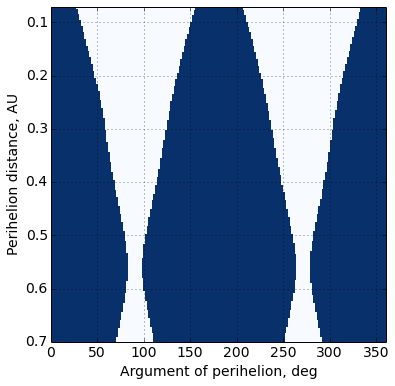

In [59]:
labels = [vd.colnames[nm] for nm in cutcol]
scales = ld.dfcommon_bounds([haz_gen_apollo_se_bottom, nohaz_gen_apollo_se_bottom], cutcol)
vd.plot_classifier(plotgrid, clfmask, num=200, figsize=(6,6), scales=scales, 
                   labels=labels, cmap='Blues', invertaxes=[0, 1])

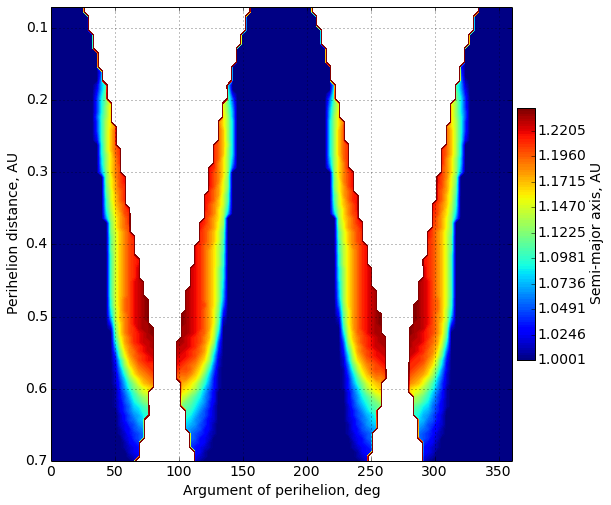

In [60]:
cutcol = ['w', 'q', 'a']
labels = [vd.colnames[nm] for nm in cutcol]
vd.plot_clf3d(clf_apollo_qa_bottom, num=100, labels=labels, figsize=(8,7), mode='2d', 
              scales=haz_gen_apollo_bottom_sc, clf_masks=[(clfmask, 0)], invertaxes=[0, 1])

** Unfortunately low-dimensional split does not work for the rest of Apollos. **

## Any Amors?

In [61]:
haz_gen_amor, haz_gen_amor_num = rdb.get_amors(haz_gen)
nohaz_gen_amor, nohaz_gen_amor_num = rdb.get_amors(nohaz_gen)

print haz_gen_amor_num
print nohaz_gen_amor_num

0
0


## Count down split quality

In [62]:
haz_correct_num = sum(map(len, haz_extracted))
nohaz_trapped_num = sum(map(len, nohaz_trapped))

haz_correct_fraction = float(haz_correct_num)/len(haz_gen)
nohaz_trapped_fraction = float(nohaz_trapped_num)/len(nohaz_gen)

haz_extracted_purity = float(haz_correct_num)/(nohaz_trapped_num + haz_correct_num)

print "Number of correctly classified PHAs", haz_correct_num
print "Number of trapped NHAs:", nohaz_trapped_num
print
print "Mass fraction of correctly classified PHAs:", haz_correct_fraction
print "Mass fraction of trapped NHAs:", nohaz_trapped_fraction
print "Cummulative purity of the outlined PHA regions:", haz_extracted_purity

Number of correctly classified PHAs 20188
Number of trapped NHAs: 1189

Mass fraction of correctly classified PHAs: 0.880918095737
Mass fraction of trapped NHAs: 0.0269235994747
Cummulative purity of the outlined PHA regions: 0.944379473266
